## I. Setup & preparation

### 1.1 - Azure OPENAI  connect

In [1]:
import os
import requests
import base64
from openai import AzureOpenAI
from config import OPENAI_API_KEY, OPENAI_API_BASE


In [2]:
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['OPENAI_API_BASE'] = OPENAI_API_BASE
os.environ['OPENAI_API_TYPE'] = 'azure'
os.environ['OPENAI_API_VERSION'] = '2024-02-15-preview'

In [ ]:
llm = AzureChatOpenAI(
    deployment_name='gpt_ob_4', #gpt_ob_4  gpt_ob_35
    model_name="gpt-4", #   gpt-35-turbo
    temperature=0,
)

In [3]:
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
from langchain.chains.llm import LLMChain
from langchain.prompts import PromptTemplate
from langchain.chat_models import AzureChatOpenAI
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
import re

### 1.2 - Tokenizer

In [4]:
# initialize tokenizer : fast open-source tokenizer by OpenAI
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4") #  gpt-35-turbo

### 1.3 - Data prep functions

In [6]:
#formatage en remplaçant les multiples retours à la ligne et les espaces excessifs
def transform_func(inputs: dict) -> dict:
    text = inputs["text"]
    
    # replace multiple new lines and multiple spaces with a single one
    # re.sub() pour nettoyer le texte en remplaçant les occurrences par des espaces
    text = re.sub(r'(\r\n|\r|\n){2,}', r'\n', text) 
    text = re.sub(r'[ \t]+', ' ', text)

    return {"output_text": text}

In [19]:
def load_and_preprocess(path: str) -> str:
    
    #charger les rapports SFCR a partir du chemin
    loader = PyPDFLoader(path)
    pages = loader.load()
    
    # Combine les pages et remplace les tabulations avec espace
    text = ""

    for page in pages:
        text += page.page_content
    
    text_refined = transform_func({'text': text}) # fonction nettoyage 
    return text_refined['output_text'] # sortie propre 

In [20]:
def save_text(text, name, version=1):
    '''
    Save generated text
    '''
    with open('1. generated_files/'+name+'_'+str(version)+'.txt', 'w') as f:
        f.write(text)

def load_text(name, version=1):
    '''
    Load generated text
    '''
    with open('1. generated_files/'+name+'_'+str(version)+'.txt', 'r') as f:
        return f.read()

## II. Methode 1 : Map Reduce

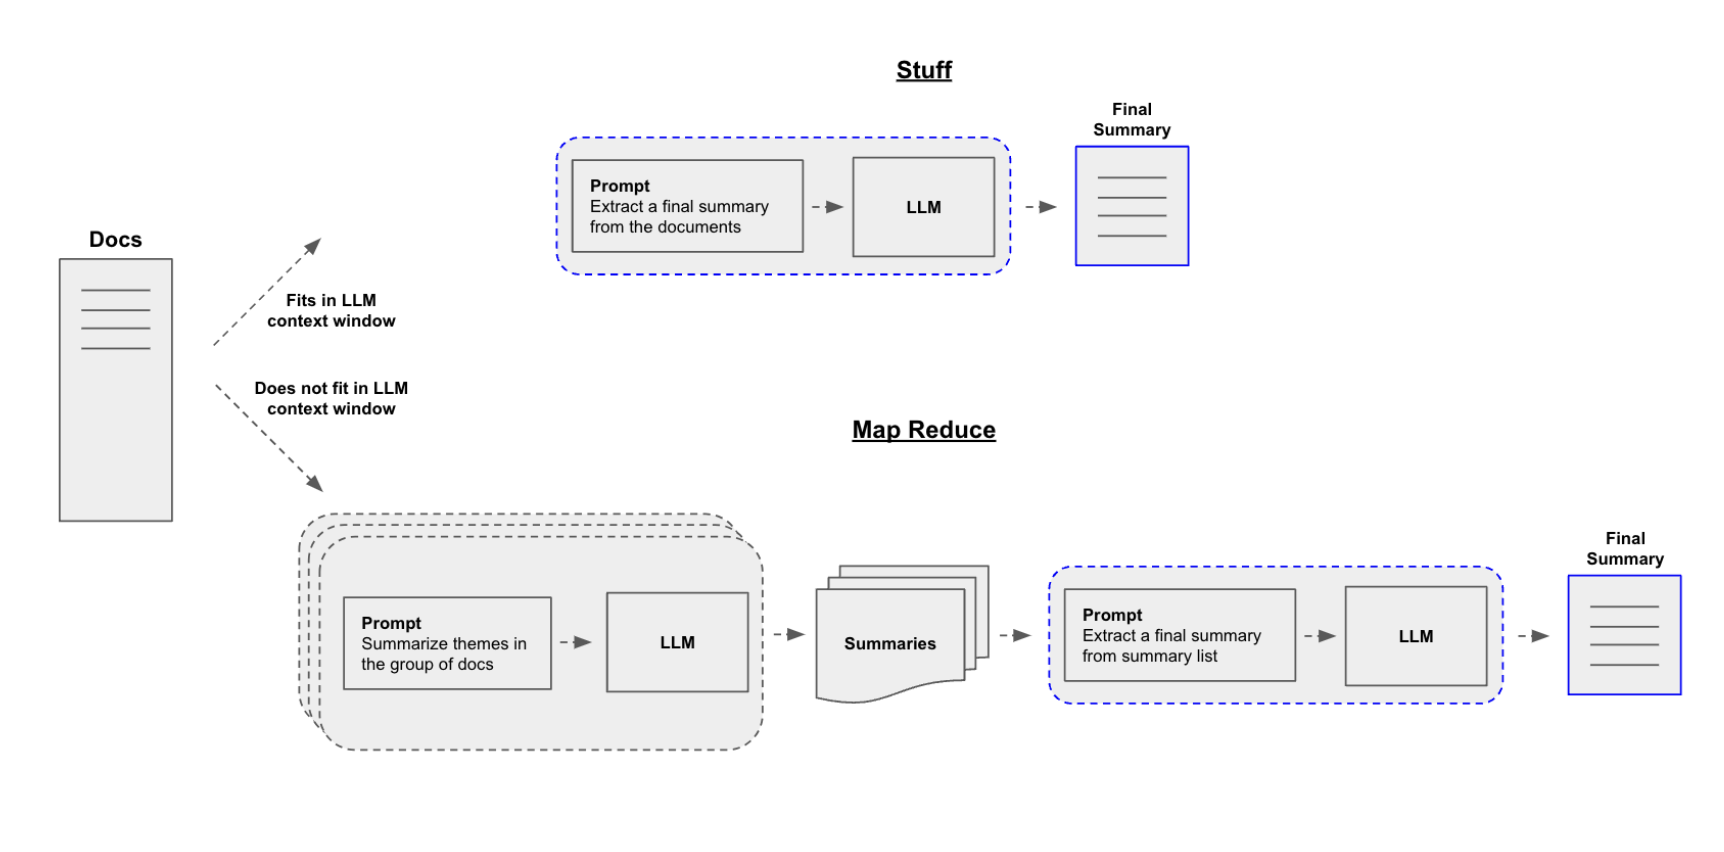

In [ ]:
from IPython.display import display, Image
chemin_image = "/Users/oussa/Desktop/DS_Projects_BaS/LLM/I.Hakathon/mapreduce.png"
display(Image(filename=chemin_image))

### 1- Fiche année N-1

In [8]:
map_prompt = """
Tu es un assistant expert dans le domaine financier et en assurance. 
Tu sais extraire le maximum d informations à partir d'un texte tout en gardant du détail. 
Ces informations sont généralement des chiffres, des montants, des pourcentages, des tendances, des explications sur les changements et les évolutions, des dates sur les thématiques suivantes:

-Présentation de l'organisme (tous les sujets relatif a : activités, histoire de création, nombre d'assurés, branche d'assurance,  secteurs d'activité, nombre d'assurés ou de sociétaires ).
-Activité de l'organisme (tous les sujets relatif a :Chiffre d'affaires, primes, Résultat technique, Résultat financier, Résultat net après impôts).
-Provisionnement (tous les sujets relatif a :  provisions techniques en valeur IFRS et Solvabilité II / 2 , la PREC ou provisions pour risques en cours des PSAP ou provisions pour sinistres a payer et des PPNA ou provisions pour primes non acquises ).
-Solvabilité (tous les sujets relatif a : SCR, modèle interne , formule standard ,  capital de solvabilité requis, ratio de solvabilité , fonds propres , pourcentage et montants de répartition du SCR par catégorie ).
-Placements autres que les actifs en represenation de contrats en UC ou indexe (tous les sujets relatif a : placements en valeur de marché , placements en valeur comptable, évolution de la valeur des placements , performances des placements, Répartition des placements par classe d'actifs).
-Changement de la gouvernance (tous les sujets relatif a : Changement de gouvernance, nomination d'un dirigeant , nouveau mandat , renouvellement de mandat ).
-Perspectives et vision de l'organisme et projets futurs et de développement (tous les sujets relatif a : Les projets futurs de développement, la stratégie ).

#Règles: 
- Tu ne dois pas modifier les valeurs des données financières (exemple: Chiffres d'affaires, pourcentages, taux, montants, ratio de solvabilité, ratio de couverture du SCR etc)
- Tu t appuiyera exclusivement sur les informations dans le texte fourni pour extraire les indicateurs financièrs et les explications des évolutions de ces indicateurs.
- Tu ne rajoutes pas d informations 
- Tu t appuiyera au maximum sur les chiffres a chaque fois que tu donnes des informations. Si tu ne les trouves pas tu n inventes pas.
- Pas la peine d'extraire les informations relatives a la conformité ( exemple a une directive ou au Règlement délégué )

Fais cet exercice tel que je l'ai décrit pour le texte suivant:
"{text}"
Résumé:
"""

map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [9]:
# contrainte de résumé allégée avec modification du prompt.
combine_prompt = """
Tu es un assistant expert dans le domaine financier et en assurance.

Ta tâche consiste à réorganiser les informations pour faire un paragraphe cohérent pour chacune des 7 parties suivantes :

'''
1.Présentation de l'organisme [Présente l'organisme, histoire de création,  branche d'assurance, secteurs d'activité, nombre d'assurés ou de sociétaires]
2.Activité [Chiffre d'affaires, primes, Résultat technique, Résultat de soucription,  Résultat financier, Résultat net après impôts, titres de participation , dividendes ]
3.Provisionnement [provisions techniques en valeur IFRS et Solvabilité II / 2  ,  la PREC ou provisions pour risques en cours,  PSAP ou provisions pour sinistres a payer , des PPNA ou provisions pour primes non acquises]
4.Placements [total actifs , placements en valeur de marché , placements en valeur comptable, évolution de la valeur des placements , performances des placements, montants ou pourcentages de répartition des Investissements par classe d'actifs ( Biens immobiliers, Détentions dans des entreprises liées, y compris participations, Actions, Obligations,Organismes de placement collectif ou OPCVM, Produits dérivés, autres ), Valeur nette des actifs corporels]
5.Solvabilité [ Ratio de solvabilité II, ratio S2, SCR et Répartition du capital de solvabilité requis sectorielle et par nature, modèle interne , formule standard ,  capital de solvabilité requis, ratio de solvabilité , fonds propres , pourcentage et montants de répartition du SCR par catégorie, Minimum de capital requis du groupe (MCR), Capacité d'absorption des pertes des impôts différés, capitaux propres ].
6.Gouvernance [Changement de gouvernance, nomination d'un dirigeant , nouveau mandat , renouvellement de mandat]
7.Perspectives [Les projets futurs de développement et la stratégie commerciale]
'''

#Règles: 
- Tu ne dois pas modifier les valeurs des données financières (EXP: Chiffres d'affaires, pourcentages, taux, montants, ratio de solvabilité, ratio de couverture du SCR etc)
- Tu t appuiyera exclusivement sur les informations dans le texte fourni.  
- Tu garderas le maximum d informations fournies sans perte d'information.
- Tu veillera a bien respecter le format fourni et les mots clés associés a chaque sujet pour bien rattacher les informations
- tu veillera a donner des explications sur l evolution de ces indicateurs quand cela est possible , si tu ne les trouve pas dans le texte tu ne les invente pas.

```{text}```
Résumé:
"""
combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [10]:
#summarization chain
summary_chain_map_reduce = load_summarize_chain(llm=llm,
                                     chain_type='map_reduce',
                                     map_prompt=map_prompt_template,
                                     combine_prompt=combine_prompt_template 
                                     #verbose=True
                                    )

In [13]:
def summarize_map_reduce(summary_chain, text:str) -> str: # deux param en entrée 
    
    ###  summary_chain pour générer un résumé de SFCR avec Map Reduce
    
    # Chunks configuration
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=10500, chunk_overlap=300)  
    docs = text_splitter.create_documents([text])

    #Calcul du nombre de  tokens avant de faire le résumé 
    length_before = len(enc.encode(text=text))
    print (f"length of text before summarization: {length_before} tokens")

    #Générer le résumé
    output = summary_chain.run(docs)

    #Calcul du nombre de tokens après résumé
    length_after = len(enc.encode(text=output))
    print (f"length of text after summarization: {length_after} tokens")

    return output


In [16]:
text = load_and_preprocess("/Users/oussa/Desktop/DS_Projects_BaS/Github/LLM_SFCR_exploit_Langchain_Azure/0. Data/SFCR-AXA-2021.pdf")


In [18]:
save_text(text, "SFCR_trans_brut", version=1)


In [ ]:
print(text)

In [ ]:
rapport_n_1 = summarize_map_reduce(summary_chain_map_reduce, text)

In [ ]:
print(rapport_n_1) 

1. Présentation de l'organisme: Le Groupe AXA est une société anonyme de droit français qui opère principalement à travers cinq hubs : France, Europe, Asie, AXA XL et International. Ses principales activités sont le Dommage, la Vie, l’Épargne et la Retraite, la Santé et la Gestion d’actifs. Récemment, le Groupe a cédé ses activités d’assurance dans la région du Golf et en Grèce, ses activités d'assurance non-Vie en Inde, ses activités bancaires en Belgique et a conclu un accord pour céder ses activités d’assurance en Malaisie et à Singapour.

2. Activité: En 2021, le chiffre d'affaires du Groupe AXA était de 99 931 millions d'euros, le résultat opérationnel part du Groupe était de 6 762 millions d'euros, le résultat net consolidé était de 7 294 millions d'euros, le total de l'actif était de 775 491 millions d'euros, les capitaux propres du Groupe étaient de 71 135 millions d'euros, la valeur des affaires nouvelles était de 2 593 millions d'euros. Les fonds propres éligibles du Groupe e

### 2 - Fiche année N

In [247]:
save_text(rapport_n_1, 'AXA_2021', version=2)

In [248]:
text = load_and_preprocess("/Users/oussa/Desktop/DS - Projects BaS/LLM/I. Hakathon/0. Data/SFCR-AXA-2022.pdf")
rapport_n = summarize_map_reduce(summary_chain_map_reduce, text)

length of text before summarization: 50384 tokens
length of text after summarization: 1287 tokens


In [249]:
print(rapport_n)

1. Présentation de l'organisme: AXA SA, créée en 1957, est la holding de tête du Groupe AXA, un leader mondial de l’assurance. Basée à Paris, elle opère dans le secteur de l'assurance et de la réassurance, gère les investissements dans les filiales du Groupe et est responsable des opérations de fusion-acquisition, du financement externe et des activités de couverture pour le Groupe AXA. En 2022, AXA SA a obtenu l'agrément administratif de l'ACPR en tant que société de réassurance et a achevé sa transformation en réassureur interne au Groupe, suite à sa fusion avec sa captive de réassurance, AXA Global Re.

2. Activité: En 2022, le chiffre d'affaires brut de la Société a augmenté de 1 971 millions d'euros pour atteindre 5 934 millions d'euros. Le résultat net de l'activité de holding a diminué de 190 millions d'euros pour atteindre 2 629 millions d'euros. Le résultat net des activités de réassurance avant impôts a diminué de 73 millions d'euros pour atteindre 180 millions d'euros. Le ré

In [250]:
save_text(rapport_n, 'AXA_2022', version=2)

In [251]:
rapport_n = load_text('AXA_2022', version=2)

### 3 - Rapport de synthèse (comparatif N vs N-1)

In [252]:
# Define prompt
prompt_template = """Tu es un assistant expert dans le domaine financier et en assurance. Tu sais identifier des potentiels
risques dans l'activité d'un organisme. Tu ne peux pas faire des calculs mathématiques complexes sans te servir d'un outil adapté.
Tu as à disposition deux rapport SFCR (Rapport sur la solvabilité et la situation financière) sur l'activité d'une entreprise de deux années
consécutives 'N' et 'N-1'. Ta tâche consiste à générer une fiche de synthèse comparative entre les deux rapports fournis sous 
le format suivant:
'''
1.Présentation [Présente l'organisme, nombre d'assurés, branche d'assurance]
2.Activité [Chiffre d'affaire, Variation par rapport à l'année 'N-1', Résultat technique, financier, net après impôts]
3.Provisionnement [Les provisions ]
4.Placements [Répartition des placements par classe d'actifs]
5.Gouvernance [Changement de gouvernance, nominations , mandats]
6.Perspectives [Les projets futurs, la stratégie]
'''

#Règles: 
- Si tu ne trouves pas l'information sur une partie donnée tu peux l'ignorer, tu ne dois rien inventer. 
- Si dans le rapport de l'année N il y déjà une comparaison avec l'année N-1 tu dois la garder.

#Rapport de l'année 'N-1'
{rapport_n_1}

#Rapport de l'année 'N'
{rapport_n}

Génération de la fiche synthèse:
"""
# we set the prompt to only have the question we ask
prompt = PromptTemplate(input_variables=['rapport_n_1','rapport_n'], template=prompt_template)

# Define LLM chain
llm_chain = LLMChain(llm=llm, prompt=prompt)

In [257]:
report = llm_chain.run(rapport_n= rapport_n, rapport_n_1= rapport_n_1)

In [254]:
print(report)

1. Présentation: AXA SA, la holding de tête du Groupe AXA, est un leader mondial de l’assurance. Basée à Paris, elle opère dans le secteur de l'assurance et de la réassurance. En 2022, AXA SA a obtenu l'agrément administratif de l'ACPR en tant que société de réassurance et a achevé sa transformation en réassureur interne au Groupe, suite à sa fusion avec sa captive de réassurance, AXA Global Re.

2. Activité: En 2022, le chiffre d'affaires brut de la Société a augmenté de 1 971 millions d'euros pour atteindre 5 934 millions d'euros. Le résultat net de l'activité de holding a diminué de 190 millions d'euros pour atteindre 2 629 millions d'euros. Le résultat net des activités de réassurance avant impôts a diminué de 73 millions d'euros pour atteindre 180 millions d'euros. Le résultat net de la Société s'est élevé à 2 809 millions d'euros en 2022.

3. Provisionnement: Le rapport de 2022 ne fournit pas de chiffres spécifiques ou de détails sur les provisions techniques, les autres passifs,

In [255]:
save_text(report, 'rapport_comparatif', version=1)

## III. Methode 2 : Refine